In [1]:
# Step 1: Import required libraries
import psycopg2
import pandas as pd
import os
from dotenv import load_dotenv
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt
import plotly.graph_objects as go


In [2]:
# Step 2: Define a function to get data between two timestamps
def get_data_between_timestamps(start_timestamp, end_timestamp):
    # Connect to your PostgreSQL database
    conn = psycopg2.connect("dbname=mydatabase user=postgres password=postgres host=db")
    cursor = conn.cursor()

    # SQL query to select data between two timestamps
    query = """
    SELECT location_id, parameter_id, unit_id, custom_parameter, timestamp, value
    FROM locations
    WHERE timestamp BETWEEN %s AND %s
    ORDER BY timestamp ASC;
    """
    cursor.execute(query, (start_timestamp, end_timestamp))
    
    # Fetch all the records
    records = cursor.fetchall()

    # Define column names for the DataFrame
    column_names = ['location_id', 'parameter_id', 'unit_id', 'custom_parameter', 'timestamp', 'value']

    # Create the DataFrame
    df = pd.DataFrame(records, columns=column_names)

    # Close the cursor and connection
    cursor.close()
    conn.close()

    # Create the mapping dictionary for units
    units_mapping = {
    "0": " ",
    "1": "C",
    "2": "F",
    "17": "psi",
    "19": "kPa",
    "20": "bar",
    "21": "mbar",
    "22": "mm Hg",
    "23": "in Hg",
    "24": "cm H₂O",
    "25": "in H₂O",
    "26": "torr",
    "27": "atm",
    "33": "mm",
    "34": "cm",
    "35": "m",
    "36": "km",
    "37": "in",
    "38": "ft",
    "49": "°",
    "65": "µS/cm",
    "66": "mS/cm",
    "81": "Ω-cm",
    "97": "psu",
    "241": "%",
    }

    # Create the mapping dictionary for parameters
    parameter_mapping = {
    1: "Temperature",
    2: "Pressure",
    3: "Depth",
    4: "Level: Depth to Water",
    5: "Level: Elevation",
    6: "Latitude",
    7: "Longitude",
    8: "Elevation",
    9: "Actual Conductivity",
    10: "Specific Conductivity",
    11: "Resistivity",
    12: "Salinity",
    13: "Total Dissolved Solids",
    14: "Density",
    16: "Baro",
    33: "Battery Level",
    }
    
    # Map the parameter_id to the parameter name
    df['parameter_id'] = df['parameter_id'].astype(int)
    df['parameter'] = df['parameter_id'].map(parameter_mapping)

    # Map the unit_id to the units name
    df['unit_id'] = df['unit_id'].astype(str)
    df['unit'] = df['unit_id'].map(units_mapping)

    # Convert the Unix timestamp to local readable datetime
    df['date'] = pd.to_datetime(df['timestamp'], unit='s')
    df['date_utc'] = pd.to_datetime(df['date'], utc=True)
    df['date'] = df['date_utc'].dt.tz_convert('America/Los_Angeles')

    df = df.sort_values(by='timestamp')
    
    return df


In [3]:
def get_usgs_data_between_dates(start_datetime, end_datetime):
    # Connect to your PostgreSQL database
    # Connect to your PostgreSQL database
    conn = psycopg2.connect("dbname=mydatabase user=postgres password=postgres host=db")
    cursor = conn.cursor()

    # SQL query to fetch data between the specified datetime values
    query = """
    SELECT site_code, site_name, latitude, longitude, variable_code, variable_name, unit_code, datetime, value, qualifier
    FROM usgs_readings
    WHERE datetime BETWEEN %s AND %s
    ORDER BY datetime ASC;
    """
    
    # Execute the query and fetch the data
    cursor.execute(query, (start_datetime, end_datetime))
    records = cursor.fetchall()

    # Define the column names for the DataFrame
    column_names = ['site_code', 'site_name', 'latitude', 'longitude', 'variable_code', 'variable_name', 'unit_code', 'datetime', 'value', 'qualifier']

    # Create the DataFrame
    df = pd.DataFrame(records, columns=column_names)

    # Close the cursor and connection
    cursor.close()
    conn.close()

    return df

In [4]:
def get_noaa_tide_predictions(start_time, end_time):
    # Connect to your PostgreSQL database
    conn = psycopg2.connect("dbname=mydatabase user=postgres password=postgres host=db")
    cursor = conn.cursor()

    # SQL query to fetch data between start_time and end_time
    query = """
    SELECT prediction_time, value, type
    FROM noaa_tide_predictions
    WHERE prediction_time BETWEEN %s AND %s
    ORDER BY prediction_time ASC;
    """

    # Execute the query with the provided start_time and end_time
    cursor.execute(query, (start_time, end_time))
    
    # Fetch all rows from the query result
    rows = cursor.fetchall()

    # Define column names for the DataFrame
    column_names = ['prediction_time', 'value', 'type']

    # Create a pandas DataFrame from the fetched data
    df = pd.DataFrame(rows, columns=column_names)
    # Add a new column 'prediction_time_est' which is 'prediction_time' minus 3 hours
    df['prediction_time_est'] = df['prediction_time'] - timedelta(hours=3)

    # Close the cursor and connection
    cursor.close()
    conn.close()

    return df

In [5]:
# Step 3: Define your start and end timestamps
days_back = 15
current_utc_time = datetime.now(timezone.utc)
start_utc_time = current_utc_time - timedelta(days=days_back)
current_unix_time = int(current_utc_time.timestamp())
start_timestamp = current_unix_time  - (days_back * 24 * 60*60)
end_timestamp = current_unix_time 
print(f"start_timestamp: {start_timestamp}  end_timestamp = {current_utc_time}")

start_timestamp: 1722604343  end_timestamp = 2024-08-17 13:12:23.120502+00:00


In [6]:
df = get_data_between_timestamps(start_timestamp, end_timestamp)

In [7]:
df1 = get_usgs_data_between_dates(start_utc_time, current_utc_time)

In [8]:
df2 = get_noaa_tide_predictions(start_utc_time, current_utc_time)

In [9]:
df2.tail()

,prediction_time,value,type,prediction_time_est
53,2024-08-16 08:38:00,8.539,H,2024-08-16 05:38:00
54,2024-08-16 16:29:00,-0.954,L,2024-08-16 13:29:00
55,2024-08-17 00:27:00,9.629,H,2024-08-16 21:27:00
56,2024-08-17 05:46:00,7.648,L,2024-08-17 02:46:00
57,2024-08-17 09:41:00,8.809,H,2024-08-17 06:41:00


In [10]:
skagit_river_mv = df1[(df1['site_name'] == "SKAGIT RIVER NEAR MOUNT VERNON, WA") & 
                 (df1['variable_name'] == "Gage height, ft")]

In [11]:
skagit_river_mv.head()

,site_code,site_name,latitude,longitude,variable_code,variable_name,unit_code,datetime,value,qualifier
1,12200500,"SKAGIT RIVER NEAR MOUNT VERNON, WA",48.444828,-122.335437,00065,"Gage height, ft",ft,2024-08-02 13:15:00,11.57,P
16,12200500,"SKAGIT RIVER NEAR MOUNT VERNON, WA",48.444828,-122.335437,00065,"Gage height, ft",ft,2024-08-02 13:30:00,11.58,P
28,12200500,"SKAGIT RIVER NEAR MOUNT VERNON, WA",48.444828,-122.335437,00065,"Gage height, ft",ft,2024-08-02 13:45:00,11.58,P
44,12200500,"SKAGIT RIVER NEAR MOUNT VERNON, WA",48.444828,-122.335437,00065,"Gage height, ft",ft,2024-08-02 14:00:00,11.59,P
58,12200500,"SKAGIT RIVER NEAR MOUNT VERNON, WA",48.444828,-122.335437,00065,"Gage height, ft",ft,2024-08-02 14:15:00,11.59,P


In [12]:
df.head()


,location_id,parameter_id,unit_id,custom_parameter,timestamp,value,parameter,unit,date,date_utc
0,6663326754275328,12,97,False,1722604500,22.411013,Salinity,psu,2024-08-02 06:15:00-07:00,2024-08-02 13:15:00+00:00
1,6407815324631040,33,241,False,1722604500,70.969650,Battery Level,%,2024-08-02 06:15:00-07:00,2024-08-02 13:15:00+00:00
2,6663326754275328,1,1,False,1722604500,15.453635,Temperature,C,2024-08-02 06:15:00-07:00,2024-08-02 13:15:00+00:00
3,6407815324631040,16,17,False,1722604500,14.789246,Baro,psi,2024-08-02 06:15:00-07:00,2024-08-02 13:15:00+00:00
4,6663326754275328,5,35,False,1722604500,1.409261,Level: Elevation,m,2024-08-02 06:15:00-07:00,2024-08-02 13:15:00+00:00


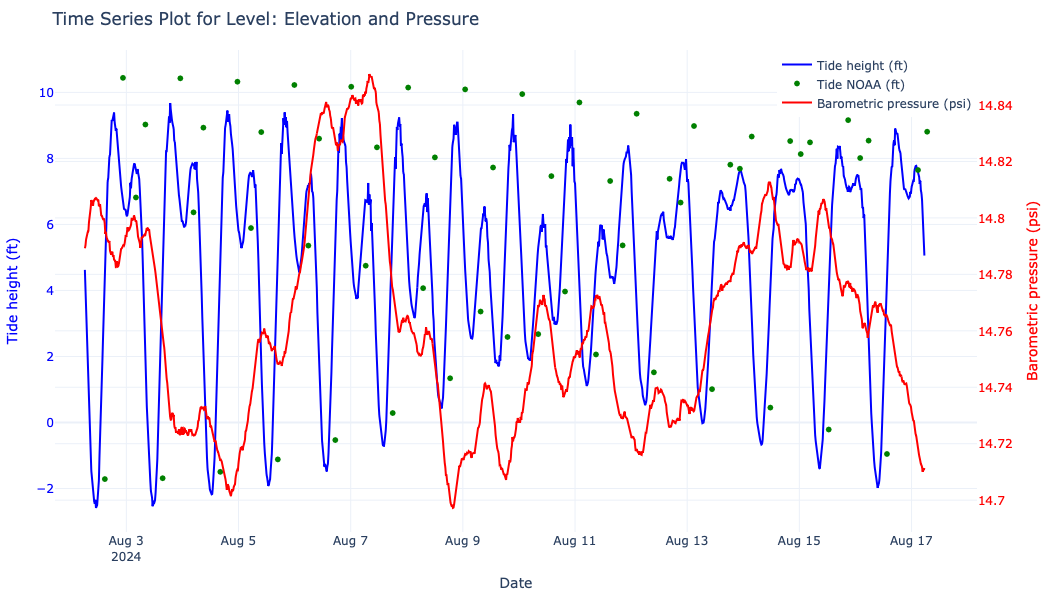

In [15]:
# Filter the DataFrame for Level: Elevation and Pressure
df_elevation = df[df['parameter'] == 'Level: Elevation'].copy() 
df_elevation['value'] = df_elevation['value'] * 3.28084
df_pressure = df[df['parameter'] == 'Pressure'].copy()
df_baro = df[df['parameter'] == 'Baro'].copy()
# Create a Plotly figure
fig = go.Figure()

# Add Level: Elevation trace
fig.add_trace(go.Scatter(
    x=df_elevation['date'],
    y=df_elevation['value'],
    mode='lines',
    name='Tide height (ft)',
    line=dict(color='blue'),
    yaxis='y1'
))

# Add Level: NOAA trace
fig.add_trace(go.Scatter(
    x=df2['prediction_time_est'] ,
    y=df2['value'],
    mode='markers',
    name='Tide NOAA (ft)',
    line=dict(color='green'),
    yaxis='y1'
))

# Add Pressure trace
fig.add_trace(go.Scatter(
    x=df_baro['date'],
    y=df_baro['value'],
    mode='lines',
    name='Barometric pressure (psi)',
    line=dict(color='red'),
    yaxis='y2'
))

# Update the layout to increase the height of the plot and move the legend
fig.update_layout(
    title='Time Series Plot for Level: Elevation and Pressure',
    xaxis=dict(title='Date'),
    yaxis=dict(
        title='Tide height (ft)',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue'),
    ),
    yaxis2=dict(
        title='Barometric pressure (psi)',
        titlefont=dict(color='red'),
        tickfont=dict(color='red'),
        overlaying='y',
        side='right'
    ),
    legend=dict(
        x=1,  # Position the legend at the far right
        y=1,  # Position the legend at the top
        xanchor='right',  # Anchor the legend's right side to the (x, y) position
        yanchor='top'  # Anchor the legend's top side to the (x, y) position
    ),
    margin=dict(l=50, r=50, t=50, b=50),
    height=600,  # Set the height to 400 pixels (approximately 4 inches)
    template='plotly_white'
)

# Show the plot
fig.show()

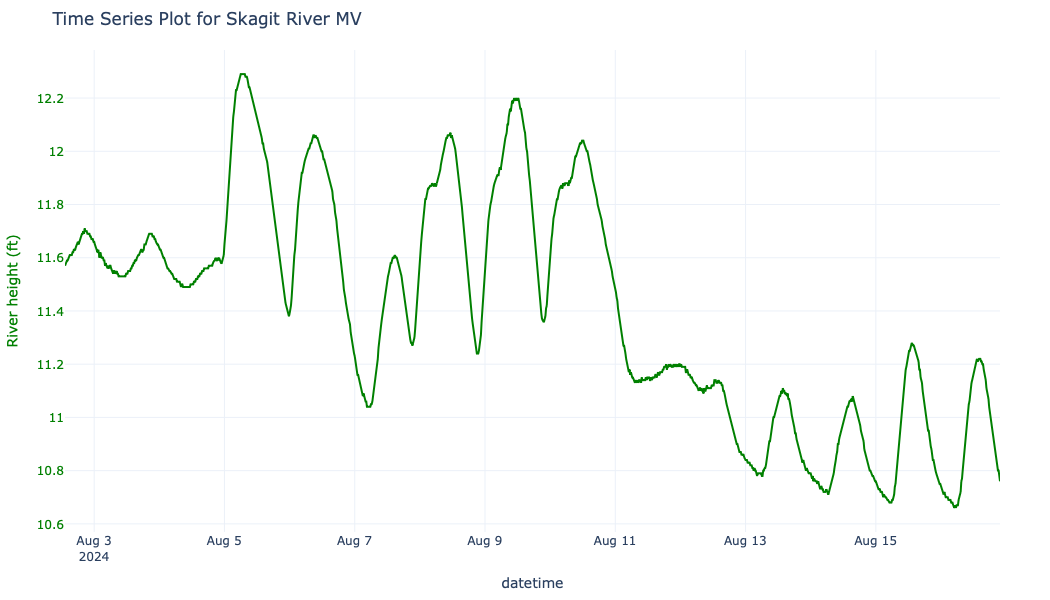

In [16]:
# Filter the DataFrame for River at MV
skagit_river_mv = df1[(df1['site_name'] == "SKAGIT RIVER NEAR MOUNT VERNON, WA") & 
                 (df1['variable_name'] == "Gage height, ft")]
# Create a Plotly figure
fig1 = go.Figure()

# Add Level: Elevation trace
fig1.add_trace(go.Scatter(
    x=skagit_river_mv['datetime'],
    y=skagit_river_mv['value'],
    mode='lines',
    name='River height (ft)',
    line=dict(color='green'),
    yaxis='y1'
))


# Update the layout to increase the height of the plot and move the legend
fig1.update_layout(
    title='Time Series Plot for Skagit River MV',
    xaxis=dict(title='datetime'),
    yaxis=dict(
        title='River height (ft)',
        titlefont=dict(color='green'),
        tickfont=dict(color='green'),
    ),
    
    legend=dict(
        x=1,  # Position the legend at the far right
        y=1,  # Position the legend at the top
        xanchor='right',  # Anchor the legend's right side to the (x, y) position
        yanchor='top'  # Anchor the legend's top side to the (x, y) position
    ),
    margin=dict(l=50, r=50, t=50, b=50),
    height=600,  # Set the height to 400 pixels (approximately 4 inches)
    template='plotly_white'
)

# Show the plot
fig1.show()